In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time
from scipy.optimize import curve_fit

In [2]:
class Node:
    def __init__(self):
        self.rank = 0
        self.size = (0, 0)
        self.singular_values = []
        self.U = None
        self.V = None
        self.children = []
        self.channels = []

    def __repr__(self):
        return f"Node(rank={self.rank}, size={self.size},\
            children={len(self.children)})"

In [3]:
def truncated_SVD(A, rank):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    return U[:, :rank], np.diag(S[:rank]), Vt[:rank, :]

In [4]:
def compress_matrix(A, tmin, tmax, smin, smax, U, D, V, r):
    node = Node()
    if np.all(A[tmin:tmax, smin:smax] == 0):
        node.rank = 0
        node.size = (tmax - tmin, smax - smin)
        return node
    
    sigma = np.diag(D)
    node.rank = r
    node.size = (tmax - tmin, smax - smin)
    node.singular_values = sigma[:r].tolist()
    node.U = U[:, :r].tolist()
    node.V = (D[:r, :r] @ V[:r, :]).tolist()
    return node

In [5]:
def create_tree(A, tmin, tmax, smin, smax, r, epsilon):
    if tmax - tmin == 1 and smax - smin == 1:
        node = Node()
        node.rank = 1
        node.size = (1, 1)
        node.U = [[1]]
        node.V = [[A[tmin, smin]]]
        node.singular_values = [A[tmin, smin]]
        return node
    
    elif tmax - tmin == 0 or smax - smin == 0:
        node = Node()
        node.rank = 0
        node.size = (0, 0)
    U, D, V = truncated_SVD(A[tmin:tmax, smin:smax], r + 1)

    if (D.shape[0] > r and D[r, r] < epsilon):
        new_r = sum(np.diag(D)[:r] > epsilon)
        return compress_matrix(A, tmin, tmax, smin, smax, U, D, V, new_r)
    
    node = Node()
    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2
    node.size = (tmax - tmin, smax - smin)

    node.children.append(create_tree(A, tmin, tmid, smin, smid, r, epsilon))
    node.children.append(create_tree(A, tmin, tmid, smid, smax, r, epsilon))
    node.children.append(create_tree(A, tmid, tmax, smin, smid, r, epsilon))
    node.children.append(create_tree(A, tmid, tmax, smid, smax, r, epsilon))
    return node

In [6]:
def reconstruct_matrix(node, tmin, tmax, smin, smax, matrix):
    if not node.children:
        if node.rank == 0:
            matrix[tmin:tmax, smin:smax] = 0
        elif node.rank == 1 and node.size == (1, 1):
            matrix[tmin, smin] = node.V[0][0]
        else:
            U = np.array(node.U)
            V = np.array(node.V)
            reconstructed_block = U @ V
            
            matrix[tmin:tmax, smin:smax] += reconstructed_block
        return
    
    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2

    reconstruct_matrix(node.children[0], tmin, tmid, smin, smid, matrix)
    reconstruct_matrix(node.children[1], tmin, tmid, smid, smax, matrix)
    reconstruct_matrix(node.children[2], tmid, tmax, smin, smid, matrix)
    reconstruct_matrix(node.children[3], tmid, tmax, smid, smax, matrix)

def reconstruct_from_tree(root, matrix_size):
    reconstructed_matrix = np.zeros(matrix_size[:2])
    reconstruct_matrix(root, 0, matrix_size[0], 0, matrix_size[1], reconstructed_matrix)
    return reconstructed_matrix

In [7]:
def draw_compressed_matrix(node, tmin, tmax, smin, smax, ax):
    if not node.children:
        rect = patches.Rectangle((smin, tmin), smax - smin, tmax - tmin, 
                                 linewidth=0.9, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        return

    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2

    draw_compressed_matrix(node.children[0], tmin, tmid, smin, smid, ax)
    draw_compressed_matrix(node.children[1], tmin, tmid, smid, smax, ax)
    draw_compressed_matrix(node.children[2], tmid, tmax, smin, smid, ax)
    draw_compressed_matrix(node.children[3], tmid, tmax, smid, smax, ax)

def visualize_compressed_matrix(matrix, root):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(matrix, cmap='gray', alpha=0.7)
    draw_compressed_matrix(root, 0, matrix.shape[0], 0, matrix.shape[1], ax)
    plt.title("Compressed Matrix Visualization")
    plt.axis('off')
    plt.show()

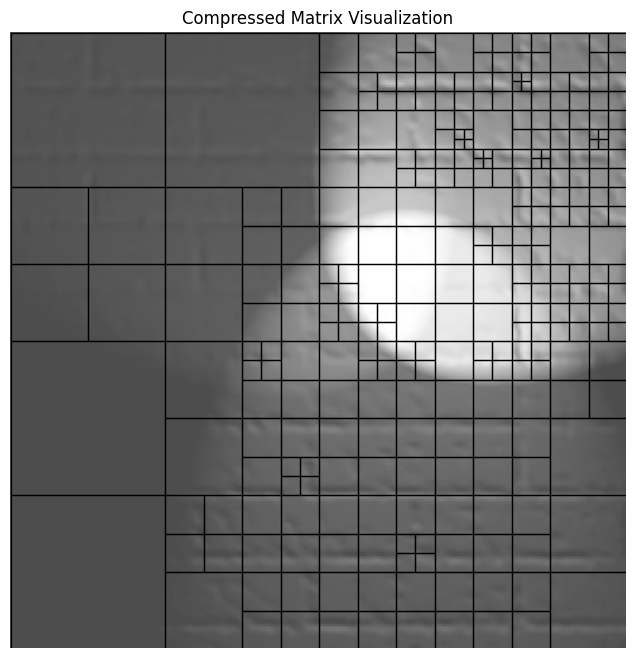

In [8]:
matrix = cv2.imread('rgb3.bmp', cv2.IMREAD_GRAYSCALE)

tmin, tmax = 0, matrix.shape[0]
smin, smax = 0, matrix.shape[1]
r = 2 
epsilon = 50 

root = create_tree(matrix, tmin, tmax, smin, smax, r, epsilon)

reconstructed_matrix = reconstruct_from_tree(root, matrix.shape)
visualize_compressed_matrix(matrix, root)

In [9]:
def matrix_vector_mult(node, x, tmin, tmax, smin, smax):
    if not node.children:
        if node.rank == 0:
            return np.zeros(tmax - tmin, dtype=float)
        
        U = np.array(node.U)
        V = np.array(node.V)
        x_sub = x[smin:smax]
        
        if node.size == (1, 1):
            return node.singular_values * x_sub
        
        tmp = V @ x_sub
        y = U @ tmp
        return y

    tmid = (tmin + tmax) // 2
    smid = (smin + smax) // 2
    y_tl = matrix_vector_mult(node.children[0], x, tmin, tmid, smin, smid)
    y_tr = matrix_vector_mult(node.children[1], x, tmin, tmid, smid, smax)
    y_bl = matrix_vector_mult(node.children[2], x, tmid, tmax, smin, smid)
    y_br = matrix_vector_mult(node.children[3], x, tmid, tmax, smid, smax)

    top = y_tl + y_tr 
    bottom = y_bl + y_br
    return np.concatenate([top, bottom])

def multiply_compressed_matrix(root, x):
    nrows, ncols = root.size
    if len(x) != ncols:
        print(root.children)
        raise ValueError("Rozmiar wektora nie pasuje do macierzy!")

    return matrix_vector_mult(root, x, 0, nrows, 0, ncols)


In [10]:
N = 32
A = np.random.rand(N, N)
r = 2
epsilon = 1e-3
root = create_tree(A, 0, N, 0, N, r, epsilon)

x = np.random.rand(N)

y_compressed = multiply_compressed_matrix(root, x)
print(y_compressed)
print(A @ x)

[7.7110947  7.16023267 8.02163024 7.69472563 8.71367058 8.1000229
 7.35297368 6.57794935 6.97994586 6.3252868  7.93524966 8.41765454
 6.77122902 8.77732756 5.67311337 7.1201939  6.69663071 7.15647254
 7.62307962 7.74948925 7.83167563 8.07118944 6.75778747 7.75009
 5.78526911 9.01187116 7.39087015 8.11044912 7.20732025 7.53647626
 8.38641989 6.57133693]
[7.7110947  7.16023267 8.02163024 7.69472563 8.71367058 8.1000229
 7.35297368 6.57794935 6.97994586 6.3252868  7.93524966 8.41765454
 6.77122902 8.77732756 5.67311337 7.1201939  6.69663071 7.15647254
 7.62307962 7.74948925 7.83167563 8.07118944 6.75778747 7.75009
 5.78526911 9.01187116 7.39087015 8.11044912 7.20732025 7.53647626
 8.38641989 6.57133693]


In [11]:
def copy_node(n: Node) -> Node:
    newn = Node()
    newn.rank = n.rank
    newn.size = n.size

    if n.U is not None:
        newn.U = [row[:] for row in n.U]
    if n.V is not None:
        newn.V = [row[:] for row in n.V]
    
    newn.children = [copy_node(ch) for ch in n.children]
    return newn

def truncated_SVD_block(A, rmax=10, eps=1e-8):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    rank_new = 0
    for s in S:
        if s > eps:
            rank_new += 1
        else:
            break
    rank_new = min(rank_new, rmax)

    if rank_new == 0:
        return (0, None, None)
    U_r = U[:, :rank_new]
    SV_r = np.diag(S[:rank_new]) @ Vt[:rank_new, :]
    return (rank_new, U_r.tolist(), SV_r.tolist())

def add_leaf_leaf(v: Node, w: Node, rmax=10, eps=1e-8) -> Node:
    Uv = np.array(v.U)
    Vv = np.array(v.V)
    Uw = np.array(w.U)
    Vw = np.array(w.V)

    A_block = Uv @ Vv
    B_block = Uw @ Vw
    C_block = A_block + B_block

    rank_new, U_r, V_r = truncated_SVD_block(C_block, rmax, eps)

    node = Node()
    node.size = v.size
    node.rank = rank_new
    if rank_new > 0:
        node.U = U_r
        node.V = V_r
    return node

def split_leaf_into_4_subleafs(v: Node):
    rows, cols = v.size
    r = v.rank
    if r == 0:
        return [copy_node(v), copy_node(v), copy_node(v), copy_node(v)]
    
    row_half = rows // 2
    col_half = cols // 2
    U_full = np.array(v.U)
    V_full = np.array(v.V)

    U_top = U_full[:row_half, :]
    U_bottom = U_full[row_half:, :]
    V_left = V_full[:, :col_half]
    V_right = V_full[:, col_half:]

    def make_subleaf(U_sub, V_sub, row_count, col_count):
        sub = Node()
        sub.size = (row_count, col_count)
        if row_count == 0 or col_count == 0 or r == 0:
            sub.rank = 0
        else:
            sub.rank = r
            sub.U = U_sub.tolist()
            sub.V = V_sub.tolist()
        return sub

    A11 = make_subleaf(U_top, V_left, row_half, col_half)
    A12 = make_subleaf(U_top, V_right, row_half, cols - col_half)
    A21 = make_subleaf(U_bottom, V_left, rows - row_half, col_half)
    A22 = make_subleaf(U_bottom, V_right, rows - row_half, cols - col_half)
    return [A11, A12, A21, A22]

In [12]:
def matrix_matrix_add(v: Node, w: Node, rmax=10, eps=1e-8) -> Node:
    if v.rank==0 and not v.children: return copy_node(w)
    if w.rank==0 and not w.children: return copy_node(v)
    if v.size != w.size:
        raise ValueError("Niezgodne rozmiary macierzy w add!")

    # 1) liść + liść
    if not v.children and not w.children:
        if v.rank == 0 and w.rank == 0:
            node = Node()
            node.size = v.size
            node.rank = 0
            return node
        
        if v.rank == 0 and w.rank > 0:
            return copy_node(w)
        if w.rank == 0 and v.rank > 0:
            return copy_node(v)
        return add_leaf_leaf(v, w, rmax, eps)

    # 2) węzeł + węzeł
    if v.children and w.children:
        node = Node()
        node.size = v.size
        A1, A2, A3, A4 = v.children
        B1, B2, B3, B4 = w.children

        C1 = matrix_matrix_add(A1, B1, rmax, eps)
        C2 = matrix_matrix_add(A2, B2, rmax, eps)
        C3 = matrix_matrix_add(A3, B3, rmax, eps)
        C4 = matrix_matrix_add(A4, B4, rmax, eps)
        node.children = [C1, C2, C3, C4]
        return node

    # 3) liść + węzeł
    if not v.children and w.children:
        sub_v = split_leaf_into_4_subleafs(v)
        node = Node()
        node.size = v.size
        node.children = [matrix_matrix_add(sub_v[0], w.children[0], rmax, eps),
                         matrix_matrix_add(sub_v[1], w.children[1], rmax, eps),
                         matrix_matrix_add(sub_v[2], w.children[2], rmax, eps),
                         matrix_matrix_add(sub_v[3], w.children[3], rmax, eps)]
        return node

    # 4) węzeł + liść
    if v.children and not w.children:
        sub_w = split_leaf_into_4_subleafs(w)
        node = Node()
        node.size = v.size
        node.children = [matrix_matrix_add(v.children[0], sub_w[0], rmax, eps),
                         matrix_matrix_add(v.children[1], sub_w[1], rmax, eps),
                         matrix_matrix_add(v.children[2], sub_w[2], rmax, eps),
                         matrix_matrix_add(v.children[3], sub_w[3], rmax, eps)]
        return node
    
    raise RuntimeError("Nieobsłużona kombinacja w matrix_matrix_add.")

In [13]:
def matrix_matrix_mult(v: Node, w: Node, rmax=10, eps=1e-8) -> Node:
    if v.rank == 0 and not v.children:
        result = Node()
        result.size = (v.size[0], w.size[1])
        result.rank = 0
        return result
    if w.rank == 0 and not w.children:
        result = Node()
        result.size = (v.size[0], w.size[1])
        result.rank = 0
        return result

    rowsA, colsA = v.size
    rowsB, colsB = w.size
    if colsA != rowsB:
        raise ValueError("Niezgodne rozmiary macierzy do mnożenia!")

    # 1) liść x liść
    if not v.children and not w.children:
        if v.rank == 0 or w.rank == 0:
            node = Node()
            node.size = (rowsA, colsB)
            node.rank = 0
            return node
        
        Uv = np.array(v.U)
        Vv = np.array(v.V)
        Uw = np.array(w.U)
        Vw = np.array(w.V)
        block = Uv @ (Vv @ Uw) @ Vw

        rank_new, U_r, V_r = truncated_SVD_block(block, rmax, eps)
        node = Node()
        node.size = (rowsA, colsB)
        node.rank = rank_new
        if rank_new > 0:
            node.U = U_r
            node.V = V_r
        return node
    
    # 2) liść x węzeł
    if not v.children and w.children:
        A1 ,A2, A3, A4 = split_leaf_into_4_subleafs(v)
        B1, B2, B3, B4 = w.children
        C1 = matrix_matrix_add(matrix_matrix_mult(A1, B1, rmax, eps),
                               matrix_matrix_mult(A2, B3, rmax, eps),
                               rmax, eps)
        C2 = matrix_matrix_add(matrix_matrix_mult(A1, B2, rmax, eps),
                               matrix_matrix_mult(A2, B4, rmax, eps),
                               rmax, eps)
        C3 = matrix_matrix_add(matrix_matrix_mult(A3, B1, rmax, eps),
                               matrix_matrix_mult(A4, B3, rmax, eps),
                               rmax, eps)
        C4 = matrix_matrix_add(matrix_matrix_mult(A3, B2, rmax, eps),
                               matrix_matrix_mult(A4, B4, rmax, eps),
                               rmax, eps)
        node = Node()
        node.size = (rowsA, colsB)
        node.children = [C1, C2, C3, C4]
        return node
    
    # 3) węzeł x liść
    if v.children and not w.children:
        B1, B2, B3, B4 = split_leaf_into_4_subleafs(w)
        A1, A2, A3, A4 = v.children
        C1 = matrix_matrix_add(matrix_matrix_mult(A1, B1, rmax, eps),
                               matrix_matrix_mult(A2, B3, rmax, eps),
                               rmax, eps)
        C2 = matrix_matrix_add(matrix_matrix_mult(A1, B2, rmax, eps),
                               matrix_matrix_mult(A2, B4, rmax, eps),
                               rmax, eps)
        C3 = matrix_matrix_add(matrix_matrix_mult(A3, B1, rmax, eps),
                               matrix_matrix_mult(A4, B3, rmax, eps),
                               rmax, eps)
        C4 = matrix_matrix_add(matrix_matrix_mult(A3, B2, rmax, eps),
                               matrix_matrix_mult(A4, B4, rmax, eps),
                               rmax, eps)
        node = Node()
        node.size = (rowsA, colsB)
        node.children = [C1, C2, C3, C4]
        return node

    # 4) węzeł x węzeł
    A1, A2, A3, A4 = v.children
    B1, B2, B3, B4 = w.children
    C1 = matrix_matrix_add(matrix_matrix_mult(A1, B1, rmax, eps),
                           matrix_matrix_mult(A2, B3, rmax, eps),
                           rmax, eps)
    C2 = matrix_matrix_add(matrix_matrix_mult(A1, B2, rmax, eps),
                           matrix_matrix_mult(A2, B4, rmax, eps),
                           rmax, eps)
    C3 = matrix_matrix_add(matrix_matrix_mult(A3, B1, rmax, eps),
                           matrix_matrix_mult(A4, B3, rmax, eps),
                           rmax, eps)
    C4 = matrix_matrix_add(matrix_matrix_mult(A3, B2, rmax, eps),
                           matrix_matrix_mult(A4, B4, rmax, eps),
                           rmax, eps)
    node = Node()
    node.size = (rowsA, colsB)
    node.children = [C1, C2, C3, C4]
    return node

In [14]:
N = 64
A = np.random.rand(N, N)
# A = np.array([
#     [1,1,1,1,1,1,7,8],
#     [2,2,2,2,2,2,6,7],
#     [3,3,3,3,3,3,5,6],
#     [4,4,4,4,4,4,4,5],
#     [5,5,5,5,5,5,3,4],
#     [6,6,6,6,6,6,2,3],
#     [7,7,7,7,7,7,1,2],
#     [8,8,8,8,8,8,8,1]
#      ])
# print(A)
r = 2
epsilon = 1.5
# epsilon = 50
root = create_tree(A, 0, N, 0, N, r, epsilon)

y_compressed = matrix_matrix_mult(root, root)
# visualize_compressed_matrix(A, root)
y = reconstruct_from_tree(y_compressed, A.shape)

print(y)
print(A @ A)

[[15.41658025 15.82133326 15.28403825 ... 15.49460771 16.22476832
  13.78244327]
 [13.62926255 14.2602936  13.70988194 ... 13.50433101 15.00982067
  12.710076  ]
 [15.65335731 15.98663525 15.56296149 ... 15.83313857 16.48252837
  14.03038208]
 ...
 [16.89873211 17.42437838 17.22161486 ... 17.34752032 18.01943415
  14.98417485]
 [16.31135928 17.23464162 16.21499879 ... 15.90724256 17.99074207
  14.59737598]
 [15.41367652 15.95922929 15.65817403 ... 15.34760171 17.28424538
  14.43481433]]
[[17.08488289 16.58698573 14.61669574 ... 14.63356305 16.85759811
  14.51385019]
 [13.12742593 14.76053585 13.15599123 ... 14.50796576 15.53524627
  12.15602329]
 [15.12180263 16.44310971 16.99896201 ... 15.69717114 15.04465738
  14.35239759]
 ...
 [17.02115707 17.54441493 19.07352152 ... 18.25218987 18.20246898
  15.17909868]
 [16.3242023  18.98970921 17.33630038 ... 16.19087756 18.09957348
  13.7081553 ]
 [15.84090231 16.32210282 15.469388   ... 15.59325205 16.24913863
  14.95404794]]


In [15]:
def generate_3d_lattice_matrix(k, random_scale=1.0):
    size_1d = 2**k
    N = (size_1d**3)
    A = np.zeros((N, N), dtype=float)

    def xyz_to_index(x, y, z):
        return x + size_1d*(y + size_1d*z)
    
    for x in range(size_1d):
        for y in range(size_1d):
            for z in range(size_1d):
                i = xyz_to_index(x, y, z)
            
                neighbors = []
                if x+1 < size_1d: neighbors.append((x+1,y,z))
                if x-1 >= 0:      neighbors.append((x-1,y,z))
                if y+1 < size_1d: neighbors.append((x,y+1,z))
                if y-1 >= 0:      neighbors.append((x,y-1,z))
                if z+1 < size_1d: neighbors.append((x,y,z+1))
                if z-1 >= 0:      neighbors.append((x,y,z-1))

                for (xn, yn, zn) in neighbors:
                    j = xyz_to_index(xn, yn, zn)
                    A[i, j] = 1 + random_scale * np.random.rand()  
    
    return A


In [16]:
def compare_frobenius_error_of_squares(A, root, r, epsilon):
    A2 = A @ A

    root_squared = matrix_matrix_mult(root, root, rmax=r, eps=epsilon)
    
    N = A.shape[0]
    H2 = np.zeros((N, N), dtype=float)
    H2 = reconstruct_from_tree(root_squared, A.shape)

    diff = A2 - H2
    frob_norm_sq = np.linalg.norm(diff, 'fro')**2
    return frob_norm_sq

In [17]:
k = 3
A = generate_3d_lattice_matrix(k, random_scale=1.0)
N = A.shape[0]
r = 10
epsilon = 2

root = create_tree(A, 0, N, 0, N, r, epsilon)

err = compare_frobenius_error_of_squares(A, root, r, epsilon)
print()
print("||A^2 - H^2||_F^2 =", err)


||A^2 - H^2||_F^2 = 108924.70669177236


In [43]:
sizes = [2, 3, 4]
times = []

for k in sizes:
    N = 2 ** (3 * k)
    A = np.random.rand(N, N)
    x = np.random.rand(N)
    print(A.shape)

    r = 2
    epsilon = 1e-3

    start = time()
    root = create_tree(A, 0, N, 0, N, r, epsilon)
    
    result = multiply_compressed_matrix(root, x)
    times.append(np.round(time() - start, 3))

print(times)

(64, 64)
(512, 512)
(4096, 4096)
[0.096, 5.414, 394.02]


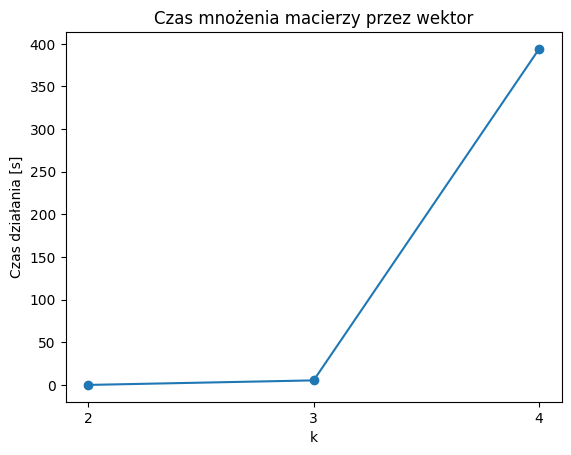

In [45]:
plt.scatter(sizes, times)
plt.plot(sizes, times)
plt.xticks(ticks=range(2, 5))
plt.xlabel("k")
plt.ylabel("Czas działania [s]")
plt.title("Czas mnożenia macierzy przez wektor")
plt.show()

In [25]:
sizes = [2, 3, 4]
times = []

for k in sizes:
    N = 2 ** (3 * k)
    A = np.random.rand(N, N)
    x = np.random.rand(N)
    print(A.shape)

    r = 2
    epsilon = 3.5

    start = time()
    root = create_tree(A, 0, N, 0, N, r, epsilon)
    
    result = matrix_matrix_mult(root, root)
    result = reconstruct_from_tree(result, A.shape)
    times.append(np.round(time() - start, 3))

print(times)

(64, 64)
(512, 512)
(4096, 4096)
[0.012, 1.77, 535.261]


In [47]:
times = [0.012, 1.77, 535.261]

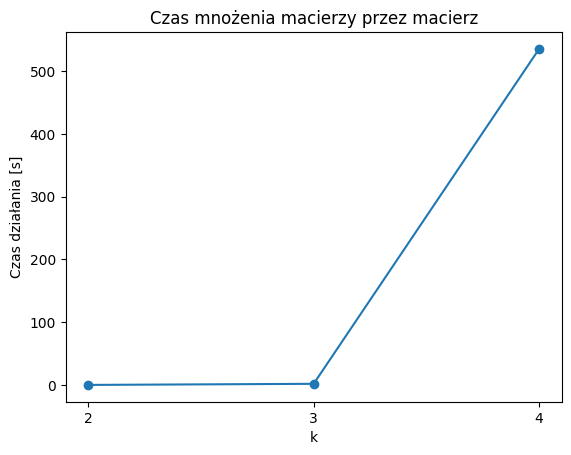

In [48]:
plt.plot(sizes, times)
plt.scatter(sizes, times)
plt.xticks(ticks=range(2, 5))
plt.xlabel("k")
plt.ylabel("Czas działania [s]")
plt.title("Czas mnożenia macierzy przez macierz")
plt.show()

1.4051045207316346e-05 2.061757338246704


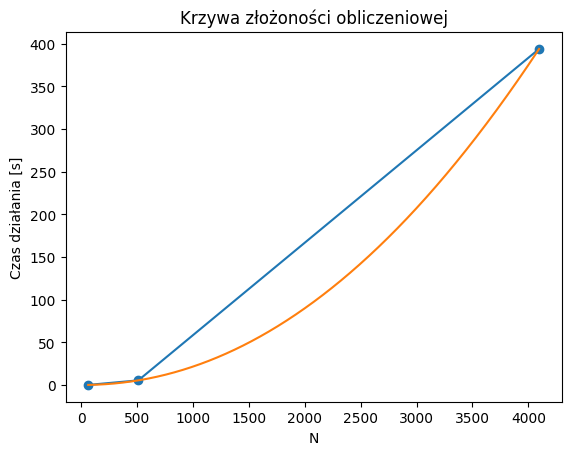

In [46]:
def model(x, alpha, beta):
    return alpha * x ** beta


sizes_lin = [2 ** 6, 2 ** 9, 2 ** 12]
w = curve_fit(model, sizes_lin, times, maxfev=10000)[0]
print(w[0], w[1])

x = np.linspace(2 ** 6, 2 ** 12, 1000)
plt.scatter(sizes_lin, times)
plt.plot(sizes_lin, times)
plt.plot(x, model(x, w[0], w[1]))

plt.xlabel("N")
plt.ylabel("Czas działania [s]")
plt.title("Krzywa złożoności obliczeniowej")
plt.show()